In [5]:
# Import python packages
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Load imputed Houston data
df_houston = pd.read_pickle("houston_df.pkl")

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


In [6]:
print(df_houston)

df_houston_raw = df_houston.copy()

                  cuisine product_type     revenue        cost    cases  \
0                   Asian     Non Food    64848.40    40577.02   1700.0   
1                   Asian     Non Food    67882.92    45765.28   1706.0   
2                   Asian     Non Food    67106.98    46050.63   1707.0   
3                   Asian     Non Food    79953.54    46981.28   1830.0   
4                   Asian     Non Food    65375.47    42107.22   1841.0   
...                   ...          ...         ...         ...      ...   
1515  Mainstream American     Proteins  1239347.31  1108906.52  12105.0   
1516  Mainstream American     Proteins  1232865.06  1096102.99  11995.0   
1517  Mainstream American     Proteins  1410584.59  1255203.38  13602.0   
1518  Mainstream American     Proteins  1372757.72  1104560.71  12246.0   
1519  Mainstream American     Proteins  1263746.98  1017769.43  12580.0   

      customer_count     city       week  
0              135.0  HOUSTON 2020-06-29  
1            

In [8]:
# Instantiate a linear model
linear_model=LinearRegression()

# Generate a uniform x variable representing the time steps
x=np.array(range(len(df_houston))).reshape(-1, 1)

# Fit the model
fit_result=linear_model.fit(x, df_houston['revenue'])

# Make predictions over the input domain
predictions=linear_model.predict(x)

# Add the linear model predictions back to the dataframe
df_houston['Linear model']=predictions

# calculate the root mean squared error
rmse=sqrt(mean_squared_error(df_houston['revenue'], predictions))

# Save the result for later
rmse_results={'Linear model': rmse}

# Display the result for the user
print(f'Root mean square error: {rmse:.1f}')

Root mean square error: 380379.4


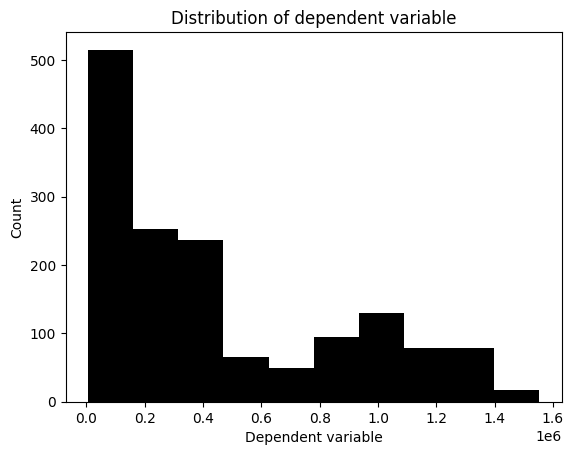

In [11]:
plt.title('Distribution of dependent variable')
plt.hist(df_houston['revenue'], color='black')
plt.xlabel('Dependent variable')
plt.ylabel('Count')
plt.show()

In [12]:
df_houston.describe()

,revenue,cost,cases,customer_count,week,Linear model
count,1.520000e+03,1.520000e+03,1520.000000,1520.000000,1520,1520.000000
mean,4.597051e+05,3.880813e+05,9216.683511,261.185505,2021-05-24 00:00:00,459705.130113
min,6.403420e+03,4.221900e+03,309.000000,40.000000,2020-06-29 00:00:00,174868.198526
25%,1.158030e+05,9.126619e+04,3729.000000,158.000000,2020-12-07 00:00:00,317286.664320
50%,3.104940e+05,2.406849e+05,7896.500000,259.000000,2021-05-24 00:00:00,459705.130113
75%,8.267410e+05,7.039884e+05,11044.000000,317.000000,2021-11-08 00:00:00,602123.595907
max,1.552379e+06,1.360824e+06,36498.000000,536.000000,2022-04-18 00:00:00,744542.061700
std,4.145856e+05,3.642313e+05,7662.254015,122.257235,NaN,164613.063919


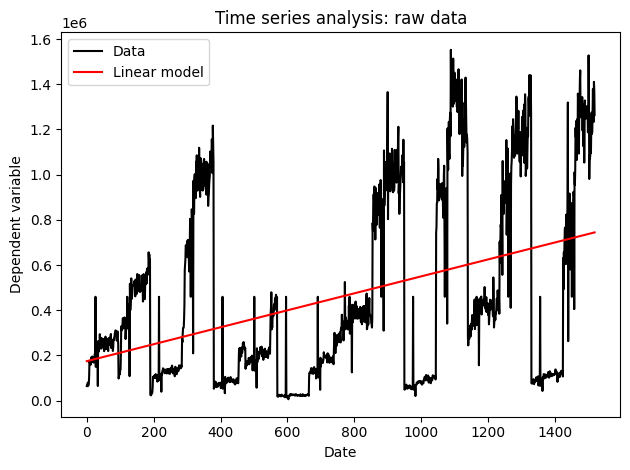

In [14]:
plt.title('Time series analysis: raw data')
plt.plot(df_houston['revenue'], label='Data', color='black')
plt.plot(df_houston['Linear model'], label='Linear model', color='red')
plt.xlabel('Date')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
# Take the difference across the datetime index
diff=np.diff(df_houston.index.to_numpy())

# Check that all of the differences are equal
equally_spaced=np.all(diff==diff[0])

print(f'Datetime axis is regular: {equally_spaced}\n')

# If the datetime axis not regular - resample it and fill in the
# missing time points with interpolation
if equally_spaced == False:

    # Resample down to days first
    resampled_timeseries_df=df_houston.resample('D').interpolate()

    # Then resample back up to months
    resampled_timeseries_df=resampled_timeseries_df.resample('ME').interpolate()
    resampled_timeseries_df.info()

    # Plot the results to be sure we didn't deform anything too badly...
    plt.title('Time series analysis: resampled vs raw data')
    plt.scatter(df_houston.index, df_houston['dependent_var'], label='Raw data', color='black')
    plt.plot(resampled_timeseries_df.index, resampled_timeseries_df['dependent_var'], label='Resampled data', color='red')
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    timeseries_df=resampled_timeseries_df

Datetime axis is regular: True



In [4]:
from pmdarima import auto_arima
import pandas as pd

# test with dummy data if needed
auto_arima([1, 2, 3, 4, 5, 6], seasonal=False, trace=True)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [62]:
weekly_revenue = df_houston.groupby('week')['revenue'].sum().asfreq('W-MON')

In [18]:
from statsmodels.tsa.stattools import adfuller

dftest=adfuller(df_houston['revenue'], autolag = "AIC")
print(f'Dicky-Fuller p-value: {dftest[1]:.3f}')

Dicky-Fuller p-value: 0.028


So stationary then

In [21]:
#timeseries_model=auto_arima(df_houston['revenue'], seasonal=True, stationary=False, trace=True, m=12)

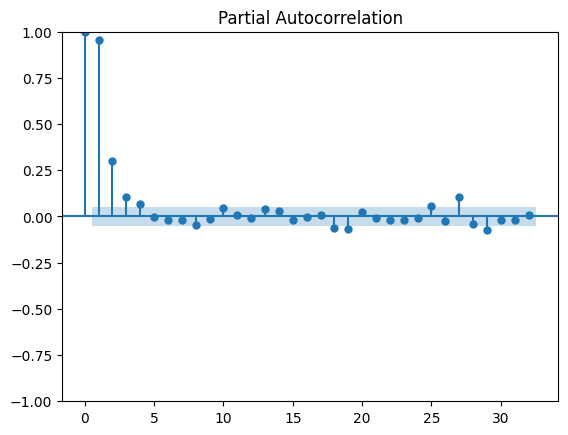

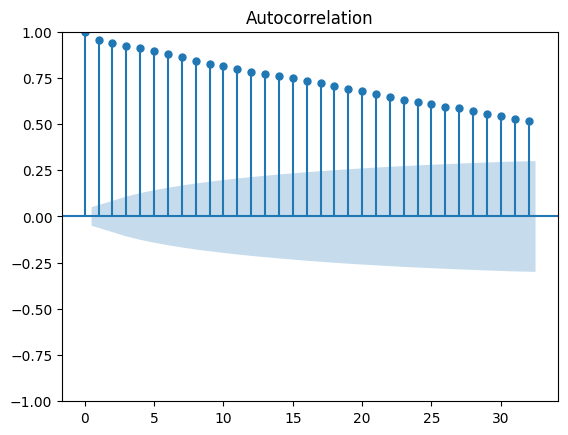

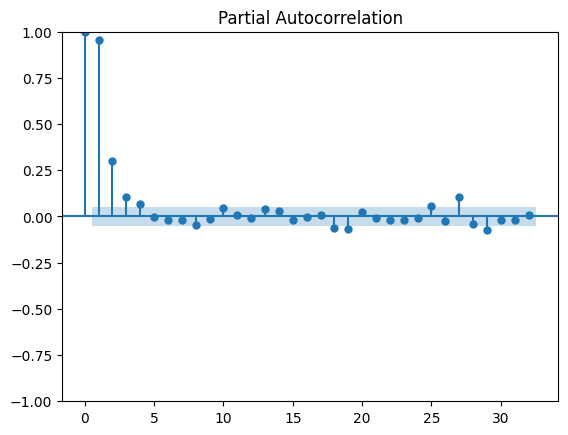

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_houston['revenue'])
plot_pacf(df_houston['revenue'])

In [32]:
df_houston['log_revenue'] = np.log(df_houston['revenue'])


In [34]:
import statsmodels.api as sm

# Define SARIMA order
order = (0, 1, 1)
seasonal_order = (0, 1, 1, 12)

# Fit the SARIMAX model on log-transformed revenue
model = sm.tsa.SARIMAX(df_houston['log_revenue'], order=order, seasonal_order=seasonal_order).fit()

# Print the model summary
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        log_revenue   No. Observations:                 1520
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -497.063
Date:                            Sat, 14 Jun 2025   AIC                           1000.125
Time:                                    11:35:16   BIC                           1016.079
Sample:                                         0   HQIC                          1006.067
                                           - 1520                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3880      0.009    -45.241      0.000      -0.405      -0.371
ma.S.L12      -0.9999      4.482   

In [64]:
weekly_revenue_diff = weekly_revenue.diff().dropna()

In [19]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(weekly_revenue_diff, order=(1, 1, 1))  
fitted = model.fit()
forecast = fitted.forecast(steps=12)

forecast_diff = fitted.forecast(steps=12)

NameError: name 'weekly_revenue_diff' is not defined

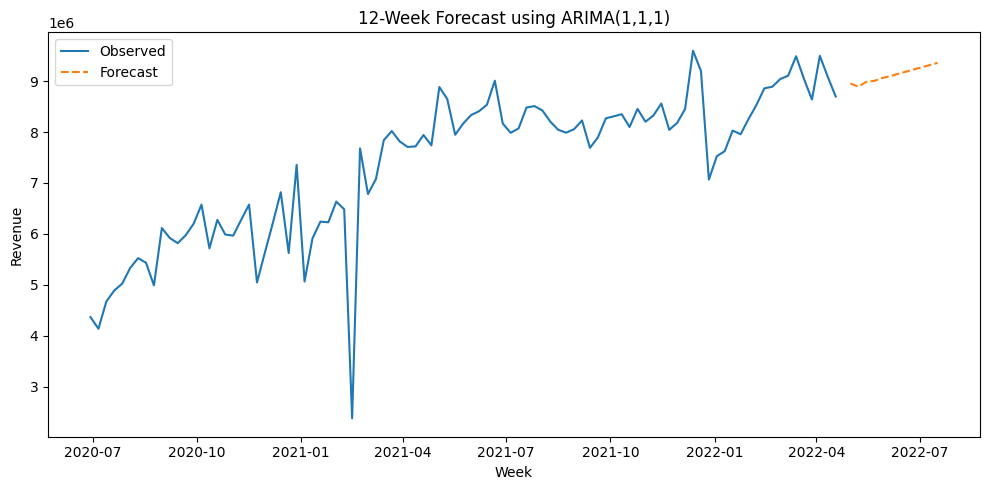

In [70]:


# Reintegrate (undo differencing)
last_observed = weekly_revenue.iloc[-1]
forecast = forecast_diff.cumsum() + last_observed

# Plot
plt.figure(figsize=(10, 5))
plt.plot(weekly_revenue.index, weekly_revenue, label='Observed')
plt.plot(pd.date_range(weekly_revenue.index[-1], periods=13, freq='W')[1:], forecast, label='Forecast', linestyle='--')
plt.title("12-Week Forecast using ARIMA(1,1,1)")
plt.xlabel("Week")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.show()

Preprocessing for TimeSeries analysis

Modeling Now